# Imports

In [1]:
import xarray as xr
import datatree
from pyart.graph import cm
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# cluster = LocalCluster()  
# client = Client(cluster)
# cluster

# 1. Radar data
Radar data is stored in `xarray datatree` structure using ARCO format. We can access all `sweeps` and all `variables` (dual polarization) by using `datatree.open_datatree` method. We converted three days of continuous radar data from Barrancabermeja radar (04-06-2023 to 04-08-2023)

In [3]:
path = '/data/keeling/a/alfonso8/gpm/zarr/BAR.zarr'

In [4]:
%%time
dt = datatree.open_datatree(path, engine='zarr', consolidated=True)

CPU times: user 917 ms, sys: 896 ms, total: 1.81 s
Wall time: 6.27 s


In [5]:
print(f'size: {dt.nbytes / (1024 ** 3)} GB')

size: 96.96776340156794 GB


This is quite a large dataset. We can "load" it in memory using lazy evaluation provided by `zarr`, `Xarray`, and `datatree`.

In [6]:
print(f"Dataset starts at: {dt['sweep_0'].times.min().values} and finishes at {dt['sweep_0'].times.max().values}")

Dataset starts at: 2023-04-06T00:00:22.709000000 and finishes at 2023-04-08T23:50:17.590000000


## 1.1 Ploting radar reflectivity on 2023-04-07 at 4:25 UTC
We can use `xarray.plot` functionality to create a reflectivity plot

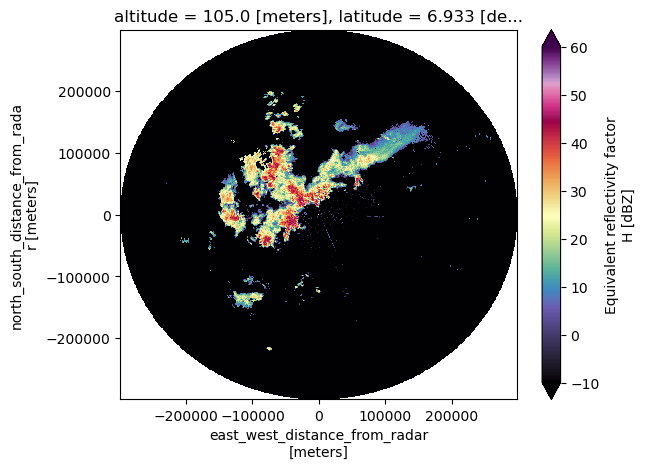

In [7]:
dt['sweep_0'].sel(times='2023-04-07 4:25', method='nearest').DBZH.plot(x='x', y='y', 
                                                                       vmin=-10, 
                                                                       vmax=60, 
                                                                       cmap='pyart_ChaseSpectral')

## 1.2 QPE using Marshall and Parmer (1948) relationship. 

In [8]:
%%time
r_total = (0.0376 * dt['sweep_0'].DBZH ** 0.6112 * 5).sum('times')

CPU times: user 11.6 s, sys: 1.78 s, total: 13.4 s
Wall time: 18.8 s


We can now visualize the total amount of rainfall rate during the 72 hours


/tmp/ipykernel_32342/2483299272.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p = ax.pcolormesh(dt['sweep_0'].x.values, dt['sweep_0'].y.values, r_total)


Text(0.5, 1.0, 'Lluvia acumulada en 72 horas')

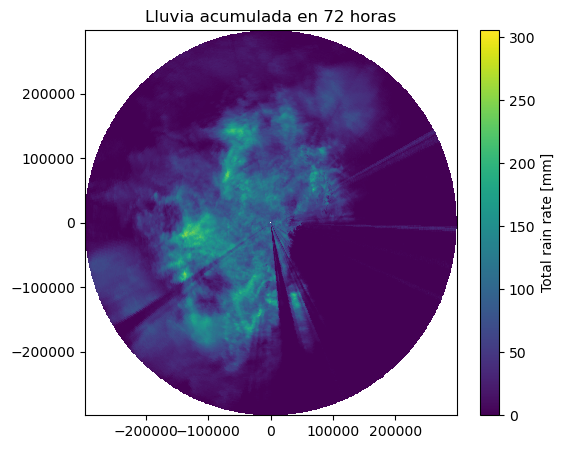

In [9]:
fig, ax = plt.subplots(figsize=(6,5))
p = ax.pcolormesh(dt['sweep_0'].x.values, dt['sweep_0'].y.values, r_total)
fig.colorbar(p, ax=ax, label='Total rain rate [mm]')
ax.set_title("Lluvia acumulada en 72 horas")

# 2. Radar data by sweeps

Loading and requesting all radar data might take a while to read from the source (see section 1). However, sometimes we only look for a specific sweep instead of "loading" all radar data into memory. `xarray datatree` scheme allows us to load by sweeps by specifying the path to the desired sweep e.g., `radar.zarr/sweep_0`. This will now substantially reduce the "loading" time and the size of the dataset.


In [10]:
%%time
ds = xr.open_zarr(f"{path}/sweep_0", consolidated=False)

CPU times: user 143 ms, sys: 33.4 ms, total: 176 ms
Wall time: 264 ms


In [11]:
print(f'size: {ds.nbytes / (1024 ** 3)} GB')

size: 23.50328565388918 GB


## 2.1 Ploting radar reflectivity

Similarly to section 1.1, we can plot the radar reflectivity. 

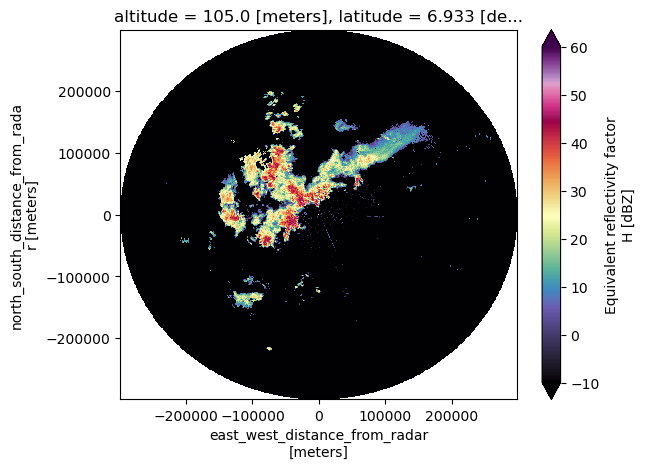

In [12]:
ds.sel(times='2023-04-07 4:25', method='nearest').DBZH.plot(x='x', y='y', 
                                                             vmin=-10, 
                                                             vmax=60, 
                                                             cmap='pyart_ChaseSpectral')

## 2.2 QPE 

We can perform exactly the same rainfall accumulation calculation and this will will be way much faster than using the whole dataset.

In [13]:
%%time
r_total_sweep = (0.0376 * ds.DBZH ** 0.6112 * 5).sum('times')

CPU times: user 37.2 ms, sys: 57.6 ms, total: 94.8 ms
Wall time: 31.2 ms


/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/tmp/ipykernel_32342/2584964139.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p = ax.pcolormesh(ds.x.values, ds.y.values, r_total_sweep)


Text(0.5, 1.0, 'Lluvia acumulada en 72 horas')

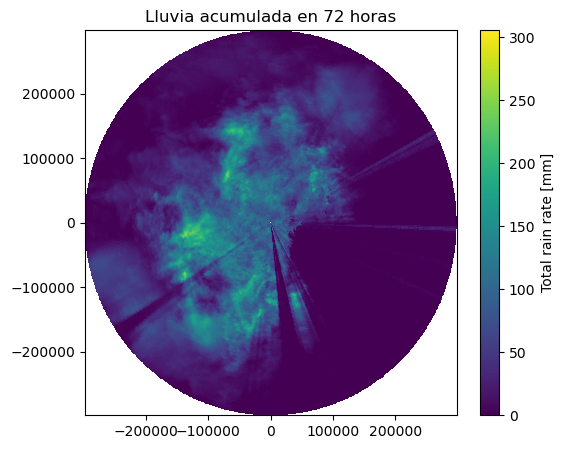

In [14]:
fig, ax = plt.subplots(figsize=(6,5))
p = ax.pcolormesh(ds.x.values, ds.y.values, r_total_sweep)
fig.colorbar(p, ax=ax, label='Total rain rate [mm]')
ax.set_title("Lluvia acumulada en 72 horas")